In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install flair

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.1/373.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.5/788.5 kB 48.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 88.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 73.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 87.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 33.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB

In [3]:
from flair.data import Corpus
from flair.datasets import ColumnCorpus
from flair.embeddings import TokenEmbeddings, WordEmbeddings, StackedEmbeddings, FlairEmbeddings, FastTextEmbeddings
from typing import List

In [6]:
# French corpus of 32 texts from ECHR (automatic and official translations) with projected annotations (reviewed)

columns = {0:'text', 1:'ner'}

corpus_folder = '/content/drive/MyDrive/.../'
corpus : Corpus = ColumnCorpus(corpus_folder, columns,
                                    train_file='FR-projected-rev.tsv', column_delimiter=' ',
                                    dev_file=None,
                                    test_file=None
)

# obtain and print corpus statistics
stats = corpus.obtain_statistics()
print(stats)

2023-09-26 07:08:30,261 Reading data from /content/drive/MyDrive/HAPLAPMaster/HAPLAPThesis/Seq-labeler
2023-09-26 07:08:30,262 Train: /content/drive/MyDrive/HAPLAPMaster/HAPLAPThesis/Seq-labeler/FR-reviewed-all-rev-shuffled.tsv
2023-09-26 07:08:30,263 Dev: None
2023-09-26 07:08:30,264 Test: None
{
    "TRAIN": {
        "dataset": "TRAIN",
        "total_number_of_documents": 1308,
        "number_of_documents_per_class": {
            "DATETIME": 518,
            "CODE": 31,
            "PER": 407,
            "LOC": 116,
            "QUANTITY": 25,
            "DEM": 47,
            "ORG": 118,
            "MISC": 76
        },
        "number_of_tokens_per_tag": {},
        "number_of_tokens": {
            "total": 38411,
            "min": 1,
            "max": 508,
            "avg": 29.366207951070336
        }
    },
    "TEST": {
        "dataset": "TEST",
        "total_number_of_documents": 162,
        "number_of_documents_per_class": {
            "DATETIME": 68,
         

In [7]:
# 2. what tag do we want to predict?
tag_type = 'ner'

# 3. make the tag dictionary from the corpus
new_tag_dictionary = corpus.make_label_dictionary(label_type=tag_type)
print(new_tag_dictionary.idx2item)

2023-09-26 07:08:53,675 Computing label dictionary. Progress:


1308it [00:00, 50974.68it/s]

2023-09-26 07:08:53,708 Dictionary created for label 'ner' with 9 values: DATETIME (seen 518 times), PER (seen 407 times), ORG (seen 118 times), LOC (seen 116 times), MISC (seen 76 times), DEM (seen 47 times), CODE (seen 31 times), QUANTITY (seen 25 times)
[b'<unk>', b'DATETIME', b'PER', b'ORG', b'LOC', b'MISC', b'DEM', b'CODE', b'QUANTITY']


In [8]:
# initialize sequence tagger
from flair.models import SequenceTagger

tagger = SequenceTagger.load("flair/ner-french")

2023-09-26 07:09:13,594 SequenceTagger predicts: Dictionary with 19 tags: O, S-LOC, B-LOC, E-LOC, I-LOC, S-PER, B-PER, E-PER, I-PER, S-MISC, B-MISC, E-MISC, I-MISC, S-ORG, B-ORG, E-ORG, I-ORG, <START>, <STOP>


In [9]:
new_tagger = SequenceTagger(tagger.embeddings, new_tag_dictionary, tag_type=tag_type)

2023-09-26 07:09:13,836 SequenceTagger predicts: Dictionary with 33 tags: O, S-DATETIME, B-DATETIME, E-DATETIME, I-DATETIME, S-PER, B-PER, E-PER, I-PER, S-ORG, B-ORG, E-ORG, I-ORG, S-LOC, B-LOC, E-LOC, I-LOC, S-MISC, B-MISC, E-MISC, I-MISC, S-DEM, B-DEM, E-DEM, I-DEM, S-CODE, B-CODE, E-CODE, I-CODE, S-QUANTITY, B-QUANTITY, E-QUANTITY, I-QUANTITY


In [10]:
# initialize trainer
from flair.trainers import ModelTrainer
trainer = ModelTrainer(new_tagger, corpus)

In [11]:
# train # train_with_dev=True
trainer.train('/content/drive/MyDrive/...',
              learning_rate=0.1,
              mini_batch_size=32,
              max_epochs=15,
              write_weights=True)
# saving the model into your drive (need to provide the full path of the folder in which you want to save the model)

2023-09-26 07:09:36,433 ----------------------------------------------------------------------------------------------------
2023-09-26 07:09:36,435 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      '0-/vol/home-vol2/ml/akbikala/.flair/embeddings/fr-wiki-fasttext-300d-1M'
      (embedding): Embedding(1000000, 300)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.5, inplace=False)
        (encoder): Embedding(275, 100)
        (rnn): LSTM(100, 1024)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.5, inplace=False)
        (encoder): Embedding(275, 100)
        (rnn): LSTM(100, 1024)
      )
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=2348, out_features=2348, bias=True)
  (rnn): LSTM(2348, 256, batch_first=True, bidirectional=True)
  (linea

100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

2023-09-26 07:09:57,006 Evaluating as a multi-label problem: False
2023-09-26 07:09:57,025 DEV : loss 0.32032233476638794 - f1-score (micro avg)  0.4956
2023-09-26 07:09:57,045 BAD EPOCHS (no improvement): 0
2023-09-26 07:09:57,049 saving best model


2023-09-26 07:10:00,484 ----------------------------------------------------------------------------------------------------
2023-09-26 07:10:01,148 epoch 2 - iter 4/41 - loss 0.36387181 - time (sec): 0.66 - samples/sec: 5430.04 - lr: 0.100000
2023-09-26 07:10:04,434 epoch 2 - iter 8/41 - loss 0.33425980 - time (sec): 3.95 - samples/sec: 1875.64 - lr: 0.100000
2023-09-26 07:10:05,590 epoch 2 - iter 12/41 - loss 0.33589792 - time (sec): 5.10 - samples/sec: 2165.84 - lr: 0.100000
2023-09-26 07:10:06,771 epoch 2 - iter 16/41 - loss 0.30316575 - time (sec): 6.28 - samples/sec: 2388.13 - lr: 0.100000
2023-09-26 07:10:07,979 epoch 2 - iter 20/41 - loss 0.30939522 - time (sec): 7.49 - samples/sec: 2493.94 - lr: 0.100000
2023-09-26 07:10:09,130 epoch 2 - iter 24/41 - loss 0.30629097 - time (sec): 8.64 - samples/sec: 2583.76 - lr: 0.100000
2023-09-26 07:10:10,306 epoch 2 - iter 28/41 - loss 0.30265181 - time (sec): 9.82 - samples/sec: 2616.82 - lr: 0.100000
2023-09-26 07:10:11,362 epoch 2 - ite

100%|██████████| 5/5 [00:01<00:00,  4.44it/s]

2023-09-26 07:10:16,669 Evaluating as a multi-label problem: False
2023-09-26 07:10:16,681 DEV : loss 0.23534196615219116 - f1-score (micro avg)  0.449


2023-09-26 07:10:16,700 BAD EPOCHS (no improvement): 1
2023-09-26 07:10:16,704 ----------------------------------------------------------------------------------------------------
2023-09-26 07:10:17,355 epoch 3 - iter 4/41 - loss 0.24241458 - time (sec): 0.65 - samples/sec: 5070.79 - lr: 0.100000
2023-09-26 07:10:18,507 epoch 3 - iter 8/41 - loss 0.20737111 - time (sec): 1.80 - samples/sec: 3731.26 - lr: 0.100000
2023-09-26 07:10:20,806 epoch 3 - iter 12/41 - loss 0.28080271 - time (sec): 4.10 - samples/sec: 2681.37 - lr: 0.100000
2023-09-26 07:10:22,115 epoch 3 - iter 16/41 - loss 0.26259428 - time (sec): 5.41 - samples/sec: 2772.26 - lr: 0.100000
2023-09-26 07:10:23,410 epoch 3 - iter 20/41 - loss 0.25003731 - time (sec): 6.70 - samples/sec: 2806.81 - lr: 0.100000
2023-09-26 07:10:24,645 epoch 3 - iter 24/41 - loss 0.24588352 - time (sec): 7.94 - samples/sec: 2838.83 - lr: 0.100000
2023-09-26 07:10:25,813 epoch 3 - iter 28/41 - loss 0.24092879 - time (sec): 9.11 - samples/sec: 2859.

100%|██████████| 5/5 [00:01<00:00,  4.26it/s]

2023-09-26 07:10:31,243 Evaluating as a multi-label problem: False
2023-09-26 07:10:31,256 DEV : loss 0.17529022693634033 - f1-score (micro avg)  0.56


2023-09-26 07:10:31,275 BAD EPOCHS (no improvement): 0
2023-09-26 07:10:31,279 saving best model
2023-09-26 07:10:35,158 ----------------------------------------------------------------------------------------------------
2023-09-26 07:10:35,948 epoch 4 - iter 4/41 - loss 0.17544936 - time (sec): 0.76 - samples/sec: 4584.15 - lr: 0.100000
2023-09-26 07:10:38,663 epoch 4 - iter 8/41 - loss 0.19912495 - time (sec): 3.48 - samples/sec: 2105.31 - lr: 0.100000
2023-09-26 07:10:39,816 epoch 4 - iter 12/41 - loss 0.18900260 - time (sec): 4.63 - samples/sec: 2429.37 - lr: 0.100000
2023-09-26 07:10:40,997 epoch 4 - iter 16/41 - loss 0.19158798 - time (sec): 5.81 - samples/sec: 2569.75 - lr: 0.100000
2023-09-26 07:10:43,097 epoch 4 - iter 20/41 - loss 0.22515816 - time (sec): 7.91 - samples/sec: 2387.75 - lr: 0.100000
2023-09-26 07:10:44,283 epoch 4 - iter 24/41 - loss 0.21871528 - time (sec): 9.10 - samples/sec: 2528.48 - lr: 0.100000
2023-09-26 07:10:45,320 epoch 4 - iter 28/41 - loss 0.214634

100%|██████████| 5/5 [00:01<00:00,  2.95it/s]

2023-09-26 07:10:51,176 Evaluating as a multi-label problem: False
2023-09-26 07:10:51,190 DEV : loss 0.16938182711601257 - f1-score (micro avg)  0.6245
2023-09-26 07:10:51,211 BAD EPOCHS (no improvement): 0
2023-09-26 07:10:51,216 saving best model


2023-09-26 07:10:54,901 ----------------------------------------------------------------------------------------------------
2023-09-26 07:10:55,667 epoch 5 - iter 4/41 - loss 0.19115978 - time (sec): 0.74 - samples/sec: 5102.18 - lr: 0.100000
2023-09-26 07:10:58,586 epoch 5 - iter 8/41 - loss 0.18994354 - time (sec): 3.66 - samples/sec: 2061.35 - lr: 0.100000
2023-09-26 07:10:59,858 epoch 5 - iter 12/41 - loss 0.19023723 - time (sec): 4.93 - samples/sec: 2301.35 - lr: 0.100000
2023-09-26 07:11:01,103 epoch 5 - iter 16/41 - loss 0.17767058 - time (sec): 6.17 - samples/sec: 2501.24 - lr: 0.100000
2023-09-26 07:11:02,345 epoch 5 - iter 20/41 - loss 0.17071861 - time (sec): 7.42 - samples/sec: 2601.09 - lr: 0.100000
2023-09-26 07:11:03,856 epoch 5 - iter 24/41 - loss 0.17082057 - time (sec): 8.93 - samples/sec: 2568.43 - lr: 0.100000
2023-09-26 07:11:05,153 epoch 5 - iter 28/41 - loss 0.16076588 - time (sec): 10.22 - samples/sec: 2603.64 - lr: 0.100000
2023-09-26 07:11:06,456 epoch 5 - it

100%|██████████| 5/5 [00:01<00:00,  3.94it/s]


2023-09-26 07:11:12,081 Evaluating as a multi-label problem: False
2023-09-26 07:11:12,095 DEV : loss 0.15681129693984985 - f1-score (micro avg)  0.6383
2023-09-26 07:11:12,113 BAD EPOCHS (no improvement): 0
2023-09-26 07:11:12,117 saving best model
2023-09-26 07:11:15,886 ----------------------------------------------------------------------------------------------------
2023-09-26 07:11:16,590 epoch 6 - iter 4/41 - loss 0.14178331 - time (sec): 0.70 - samples/sec: 5132.09 - lr: 0.100000
2023-09-26 07:11:19,991 epoch 6 - iter 8/41 - loss 0.16411429 - time (sec): 4.10 - samples/sec: 1794.83 - lr: 0.100000
2023-09-26 07:11:21,176 epoch 6 - iter 12/41 - loss 0.15367091 - time (sec): 5.29 - samples/sec: 2100.56 - lr: 0.100000
2023-09-26 07:11:22,430 epoch 6 - iter 16/41 - loss 0.14578730 - time (sec): 6.54 - samples/sec: 2267.01 - lr: 0.100000
2023-09-26 07:11:23,826 epoch 6 - iter 20/41 - loss 0.14465234 - time (sec): 7.94 - samples/sec: 2370.18 - lr: 0.100000
2023-09-26 07:11:24,941 epo

100%|██████████| 5/5 [00:01<00:00,  4.32it/s]

2023-09-26 07:11:32,654 Evaluating as a multi-label problem: False


2023-09-26 07:11:32,669 DEV : loss 0.14944617450237274 - f1-score (micro avg)  0.6835
2023-09-26 07:11:32,688 BAD EPOCHS (no improvement): 0
2023-09-26 07:11:32,691 saving best model
2023-09-26 07:11:38,226 ----------------------------------------------------------------------------------------------------
2023-09-26 07:11:38,947 epoch 7 - iter 4/41 - loss 0.13027798 - time (sec): 0.72 - samples/sec: 5318.96 - lr: 0.100000
2023-09-26 07:11:40,154 epoch 7 - iter 8/41 - loss 0.12360797 - time (sec): 1.93 - samples/sec: 3983.35 - lr: 0.100000
2023-09-26 07:11:41,387 epoch 7 - iter 12/41 - loss 0.13067136 - time (sec): 3.16 - samples/sec: 3567.89 - lr: 0.100000
2023-09-26 07:11:42,450 epoch 7 - iter 16/41 - loss 0.13705795 - time (sec): 4.22 - samples/sec: 3558.12 - lr: 0.100000
2023-09-26 07:11:43,497 epoch 7 - iter 20/41 - loss 0.13298258 - time (sec): 5.27 - samples/sec: 3531.54 - lr: 0.100000
2023-09-26 07:11:46,229 epoch 7 - iter 24/41 - loss 0.15183771 - time (sec): 8.00 - samples/se

100%|██████████| 5/5 [00:01<00:00,  3.89it/s]

2023-09-26 07:11:53,386 Evaluating as a multi-label problem: False


2023-09-26 07:11:53,401 DEV : loss 0.15967756509780884 - f1-score (micro avg)  0.6019
2023-09-26 07:11:53,420 BAD EPOCHS (no improvement): 1
2023-09-26 07:11:53,424 ----------------------------------------------------------------------------------------------------
2023-09-26 07:11:54,138 epoch 8 - iter 4/41 - loss 0.11968688 - time (sec): 0.71 - samples/sec: 4957.34 - lr: 0.100000
2023-09-26 07:11:55,480 epoch 8 - iter 8/41 - loss 0.11478015 - time (sec): 2.05 - samples/sec: 3503.65 - lr: 0.100000
2023-09-26 07:11:56,773 epoch 8 - iter 12/41 - loss 0.11584897 - time (sec): 3.35 - samples/sec: 3301.21 - lr: 0.100000
2023-09-26 07:11:57,928 epoch 8 - iter 16/41 - loss 0.11772383 - time (sec): 4.50 - samples/sec: 3243.65 - lr: 0.100000
2023-09-26 07:11:59,100 epoch 8 - iter 20/41 - loss 0.11587524 - time (sec): 5.67 - samples/sec: 3241.12 - lr: 0.100000
2023-09-26 07:12:00,399 epoch 8 - iter 24/41 - loss 0.11527358 - time (sec): 6.97 - samples/sec: 3180.84 - lr: 0.100000
2023-09-26 07:12

100%|██████████| 5/5 [00:01<00:00,  2.82it/s]

2023-09-26 07:12:09,054 Evaluating as a multi-label problem: False
2023-09-26 07:12:09,067 DEV : loss 0.134246826171875 - f1-score (micro avg)  0.6639
2023-09-26 07:12:09,084 BAD EPOCHS (no improvement): 2
2023-09-26 07:12:09,089 ----------------------------------------------------------------------------------------------------


2023-09-26 07:12:09,924 epoch 9 - iter 4/41 - loss 0.09230592 - time (sec): 0.83 - samples/sec: 5006.47 - lr: 0.100000
2023-09-26 07:12:11,199 epoch 9 - iter 8/41 - loss 0.08373005 - time (sec): 2.11 - samples/sec: 3722.26 - lr: 0.100000
2023-09-26 07:12:12,429 epoch 9 - iter 12/41 - loss 0.10773763 - time (sec): 3.34 - samples/sec: 3415.67 - lr: 0.100000
2023-09-26 07:12:13,690 epoch 9 - iter 16/41 - loss 0.10749035 - time (sec): 4.60 - samples/sec: 3202.99 - lr: 0.100000
2023-09-26 07:12:14,968 epoch 9 - iter 20/41 - loss 0.11174295 - time (sec): 5.88 - samples/sec: 3138.58 - lr: 0.100000
2023-09-26 07:12:16,258 epoch 9 - iter 24/41 - loss 0.11587593 - time (sec): 7.17 - samples/sec: 3195.27 - lr: 0.100000
2023-09-26 07:12:17,415 epoch 9 - iter 28/41 - loss 0.11699214 - time (sec): 8.32 - samples/sec: 3185.80 - lr: 0.100000
2023-09-26 07:12:19,640 epoch 9 - iter 32/41 - loss 0.12371015 - time (sec): 10.55 - samples/sec: 2904.96 - lr: 0.100000
2023-09-26 07:12:20,777 epoch 9 - iter 36

100%|██████████| 5/5 [00:01<00:00,  4.18it/s]

2023-09-26 07:12:23,892 Evaluating as a multi-label problem: False


2023-09-26 07:12:23,907 DEV : loss 0.13047759234905243 - f1-score (micro avg)  0.659
2023-09-26 07:12:23,928 BAD EPOCHS (no improvement): 3
2023-09-26 07:12:23,933 ----------------------------------------------------------------------------------------------------
2023-09-26 07:12:25,679 epoch 10 - iter 4/41 - loss 0.13840072 - time (sec): 1.75 - samples/sec: 2496.22 - lr: 0.100000
2023-09-26 07:12:26,755 epoch 10 - iter 8/41 - loss 0.13149218 - time (sec): 2.82 - samples/sec: 2902.69 - lr: 0.100000
2023-09-26 07:12:27,828 epoch 10 - iter 12/41 - loss 0.12955815 - time (sec): 3.89 - samples/sec: 2986.93 - lr: 0.100000
2023-09-26 07:12:28,897 epoch 10 - iter 16/41 - loss 0.13160315 - time (sec): 4.96 - samples/sec: 3060.56 - lr: 0.100000
2023-09-26 07:12:30,001 epoch 10 - iter 20/41 - loss 0.12551406 - time (sec): 6.07 - samples/sec: 3112.15 - lr: 0.100000
2023-09-26 07:12:31,102 epoch 10 - iter 24/41 - loss 0.12374589 - time (sec): 7.17 - samples/sec: 3132.99 - lr: 0.100000
2023-09-26 

100%|██████████| 5/5 [00:01<00:00,  4.08it/s]

2023-09-26 07:12:37,668 Evaluating as a multi-label problem: False
2023-09-26 07:12:37,682 DEV : loss 0.12130903452634811 - f1-score (micro avg)  0.7073
2023-09-26 07:12:37,701 BAD EPOCHS (no improvement): 0
2023-09-26 07:12:37,705 saving best model


2023-09-26 07:12:41,980 ----------------------------------------------------------------------------------------------------
2023-09-26 07:12:42,679 epoch 11 - iter 4/41 - loss 0.10208451 - time (sec): 0.70 - samples/sec: 5255.61 - lr: 0.100000
2023-09-26 07:12:46,571 epoch 11 - iter 8/41 - loss 0.14594467 - time (sec): 4.59 - samples/sec: 1706.89 - lr: 0.100000
2023-09-26 07:12:47,816 epoch 11 - iter 12/41 - loss 0.12237617 - time (sec): 5.83 - samples/sec: 1973.67 - lr: 0.100000
2023-09-26 07:12:49,045 epoch 11 - iter 16/41 - loss 0.11574302 - time (sec): 7.06 - samples/sec: 2176.20 - lr: 0.100000
2023-09-26 07:12:50,411 epoch 11 - iter 20/41 - loss 0.11596559 - time (sec): 8.43 - samples/sec: 2265.36 - lr: 0.100000
2023-09-26 07:12:51,577 epoch 11 - iter 24/41 - loss 0.12411919 - time (sec): 9.59 - samples/sec: 2354.50 - lr: 0.100000
2023-09-26 07:12:52,809 epoch 11 - iter 28/41 - loss 0.12203476 - time (sec): 10.83 - samples/sec: 2400.03 - lr: 0.100000
2023-09-26 07:12:54,177 epoch

100%|██████████| 5/5 [00:01<00:00,  4.06it/s]

2023-09-26 07:12:58,728 Evaluating as a multi-label problem: False
2023-09-26 07:12:58,741 DEV : loss 0.13264314830303192 - f1-score (micro avg)  0.7083


2023-09-26 07:12:58,760 BAD EPOCHS (no improvement): 0
2023-09-26 07:12:58,765 saving best model
2023-09-26 07:13:02,655 ----------------------------------------------------------------------------------------------------
2023-09-26 07:13:03,324 epoch 12 - iter 4/41 - loss 0.09057206 - time (sec): 0.67 - samples/sec: 5343.25 - lr: 0.100000
2023-09-26 07:13:06,242 epoch 12 - iter 8/41 - loss 0.10283354 - time (sec): 3.59 - samples/sec: 2026.38 - lr: 0.100000
2023-09-26 07:13:07,440 epoch 12 - iter 12/41 - loss 0.09504819 - time (sec): 4.78 - samples/sec: 2315.54 - lr: 0.100000
2023-09-26 07:13:08,663 epoch 12 - iter 16/41 - loss 0.10163451 - time (sec): 6.01 - samples/sec: 2457.81 - lr: 0.100000
2023-09-26 07:13:10,949 epoch 12 - iter 20/41 - loss 0.11048615 - time (sec): 8.29 - samples/sec: 2271.67 - lr: 0.100000
2023-09-26 07:13:12,489 epoch 12 - iter 24/41 - loss 0.10703424 - time (sec): 9.83 - samples/sec: 2321.44 - lr: 0.100000
2023-09-26 07:13:13,662 epoch 12 - iter 28/41 - loss 0

100%|██████████| 5/5 [00:01<00:00,  4.07it/s]

2023-09-26 07:13:19,161 Evaluating as a multi-label problem: False
2023-09-26 07:13:19,173 DEV : loss 0.1162208765745163 - f1-score (micro avg)  0.6894


2023-09-26 07:13:19,192 BAD EPOCHS (no improvement): 1
2023-09-26 07:13:19,196 ----------------------------------------------------------------------------------------------------
2023-09-26 07:13:20,305 epoch 13 - iter 4/41 - loss 0.07597298 - time (sec): 1.11 - samples/sec: 3424.68 - lr: 0.100000
2023-09-26 07:13:21,670 epoch 13 - iter 8/41 - loss 0.09891561 - time (sec): 2.47 - samples/sec: 3070.46 - lr: 0.100000
2023-09-26 07:13:22,970 epoch 13 - iter 12/41 - loss 0.09552590 - time (sec): 3.77 - samples/sec: 3053.43 - lr: 0.100000
2023-09-26 07:13:24,416 epoch 13 - iter 16/41 - loss 0.10169682 - time (sec): 5.22 - samples/sec: 2986.63 - lr: 0.100000
2023-09-26 07:13:25,609 epoch 13 - iter 20/41 - loss 0.09972929 - time (sec): 6.41 - samples/sec: 2990.47 - lr: 0.100000
2023-09-26 07:13:26,908 epoch 13 - iter 24/41 - loss 0.09643643 - time (sec): 7.71 - samples/sec: 2971.64 - lr: 0.100000
2023-09-26 07:13:27,986 epoch 13 - iter 28/41 - loss 0.09644107 - time (sec): 8.79 - samples/sec

100%|██████████| 5/5 [00:01<00:00,  4.02it/s]

2023-09-26 07:13:34,283 Evaluating as a multi-label problem: False
2023-09-26 07:13:34,295 DEV : loss 0.11698547005653381 - f1-score (micro avg)  0.6984
2023-09-26 07:13:34,312 BAD EPOCHS (no improvement): 2
2023-09-26 07:13:34,316 ----------------------------------------------------------------------------------------------------


2023-09-26 07:13:35,034 epoch 14 - iter 4/41 - loss 0.08519018 - time (sec): 0.72 - samples/sec: 4965.37 - lr: 0.100000
2023-09-26 07:13:36,293 epoch 14 - iter 8/41 - loss 0.07964981 - time (sec): 1.97 - samples/sec: 3850.83 - lr: 0.100000
2023-09-26 07:13:37,422 epoch 14 - iter 12/41 - loss 0.07822651 - time (sec): 3.10 - samples/sec: 3641.81 - lr: 0.100000
2023-09-26 07:13:38,581 epoch 14 - iter 16/41 - loss 0.07957587 - time (sec): 4.26 - samples/sec: 3385.80 - lr: 0.100000
2023-09-26 07:13:39,898 epoch 14 - iter 20/41 - loss 0.08199870 - time (sec): 5.58 - samples/sec: 3301.04 - lr: 0.100000
2023-09-26 07:13:41,140 epoch 14 - iter 24/41 - loss 0.08673127 - time (sec): 6.82 - samples/sec: 3214.96 - lr: 0.100000
2023-09-26 07:13:42,290 epoch 14 - iter 28/41 - loss 0.08566018 - time (sec): 7.97 - samples/sec: 3187.84 - lr: 0.100000
2023-09-26 07:13:44,476 epoch 14 - iter 32/41 - loss 0.09228630 - time (sec): 10.16 - samples/sec: 2948.98 - lr: 0.100000
2023-09-26 07:13:45,579 epoch 14 

100%|██████████| 5/5 [00:01<00:00,  4.35it/s]

2023-09-26 07:13:48,500 Evaluating as a multi-label problem: False
2023-09-26 07:13:48,512 DEV : loss 0.11861828714609146 - f1-score (micro avg)  0.6967


2023-09-26 07:13:48,531 BAD EPOCHS (no improvement): 3
2023-09-26 07:13:48,535 ----------------------------------------------------------------------------------------------------
2023-09-26 07:13:49,292 epoch 15 - iter 4/41 - loss 0.07275634 - time (sec): 0.76 - samples/sec: 4780.14 - lr: 0.100000
2023-09-26 07:13:50,514 epoch 15 - iter 8/41 - loss 0.07957292 - time (sec): 1.98 - samples/sec: 3866.33 - lr: 0.100000
2023-09-26 07:13:51,568 epoch 15 - iter 12/41 - loss 0.08467921 - time (sec): 3.03 - samples/sec: 3675.41 - lr: 0.100000
2023-09-26 07:13:52,709 epoch 15 - iter 16/41 - loss 0.09068303 - time (sec): 4.17 - samples/sec: 3631.50 - lr: 0.100000
2023-09-26 07:13:54,922 epoch 15 - iter 20/41 - loss 0.09391157 - time (sec): 6.38 - samples/sec: 3013.17 - lr: 0.100000
2023-09-26 07:13:56,117 epoch 15 - iter 24/41 - loss 0.09578046 - time (sec): 7.58 - samples/sec: 3011.03 - lr: 0.100000
2023-09-26 07:13:57,269 epoch 15 - iter 28/41 - loss 0.09409102 - time (sec): 8.73 - samples/sec

100%|██████████| 5/5 [00:01<00:00,  4.28it/s]

2023-09-26 07:14:02,556 Evaluating as a multi-label problem: False
2023-09-26 07:14:02,568 DEV : loss 0.11085504293441772 - f1-score (micro avg)  0.7097


2023-09-26 07:14:02,587 BAD EPOCHS (no improvement): 0
2023-09-26 07:14:02,591 saving best model
2023-09-26 07:14:11,826 ----------------------------------------------------------------------------------------------------
2023-09-26 07:14:15,526 SequenceTagger predicts: Dictionary with 35 tags: O, S-DATETIME, B-DATETIME, E-DATETIME, I-DATETIME, S-PER, B-PER, E-PER, I-PER, S-ORG, B-ORG, E-ORG, I-ORG, S-LOC, B-LOC, E-LOC, I-LOC, S-MISC, B-MISC, E-MISC, I-MISC, S-DEM, B-DEM, E-DEM, I-DEM, S-CODE, B-CODE, E-CODE, I-CODE, S-QUANTITY, B-QUANTITY, E-QUANTITY, I-QUANTITY, <START>, <STOP>


100%|██████████| 6/6 [00:01<00:00,  3.53it/s]

2023-09-26 07:14:17,646 Evaluating as a multi-label problem: False
2023-09-26 07:14:17,660 0.8099	0.7419	0.7744	0.6425
2023-09-26 07:14:17,661 
Results:
- F-score (micro) 0.7744
- F-score (macro) 0.5915
- Accuracy 0.6425

By class:
              precision    recall  f1-score   support

    DATETIME     0.8906    0.8382    0.8636        68
         PER     0.7778    0.9333    0.8485        45
         LOC     0.5556    0.5000    0.5263        10
        MISC     0.6667    0.2000    0.3077        10
         ORG     1.0000    0.3333    0.5000         9
    QUANTITY     0.6000    0.6000    0.6000         5
         DEM     1.0000    0.1667    0.2857         6
        CODE     0.6667    1.0000    0.8000         2

   micro avg     0.8099    0.7419    0.7744       155
   macro avg     0.7697    0.5714    0.5915       155
weighted avg     0.8201    0.7419    0.7488       155

2023-09-26 07:14:17,663 ---------------------------------------------------------------------------------------------

{'test_score': 0.7744107744107744,
 'dev_score_history': [0.49557522123893816,
  0.4489795918367347,
  0.5599999999999999,
  0.6244725738396624,
  0.6382978723404255,
  0.6835443037974683,
  0.601851851851852,
  0.6639344262295082,
  0.6590038314176245,
  0.7073170731707317,
  0.7083333333333335,
  0.6893939393939394,
  0.6984126984126985,
  0.6967213114754099,
  0.7096774193548386],
 'train_loss_history': [0.7046587714792394,
  0.3168752089855445,
  0.22788320219956523,
  0.20602183965042567,
  0.1706392394919424,
  0.16120323706913384,
  0.14164119856616594,
  0.12949026544316733,
  0.12367684438132957,
  0.11374139955839473,
  0.1129182329565424,
  0.1034011405831012,
  0.12032553744370102,
  0.09303506350313061,
  0.09722035496830335],
 'dev_loss_history': [0.32032233476638794,
  0.23534196615219116,
  0.17529022693634033,
  0.16938182711601257,
  0.15681129693984985,
  0.14944617450237274,
  0.15967756509780884,
  0.134246826171875,
  0.13047759234905243,
  0.12130903452634811,
  

2023-09-26 07:14:17,681 ----------------------------------------------------------------------------------------------------
2023-09-26 07:14:17,682 WARNING: No LOSS found for test split in this data.
2023-09-26 07:14:17,683 Are you sure you want to plot LOSS and not another value?
2023-09-26 07:14:17,685 ----------------------------------------------------------------------------------------------------
2023-09-26 07:14:17,715 ----------------------------------------------------------------------------------------------------
2023-09-26 07:14:17,717 WARNING: No F1 found for test split in this data.
2023-09-26 07:14:17,717 Are you sure you want to plot F1 and not another value?
2023-09-26 07:14:17,718 ----------------------------------------------------------------------------------------------------
2023-09-26 07:14:18,833 Loss and F1 plots are saved in /content/drive/MyDrive/HAPLAPMaster/HAPLAPThesis/Seq-labeler/Flair-FR/Flair-ECHR-train-FR/Flair-Hug-model-FR-all-rev-shuffled/trainin

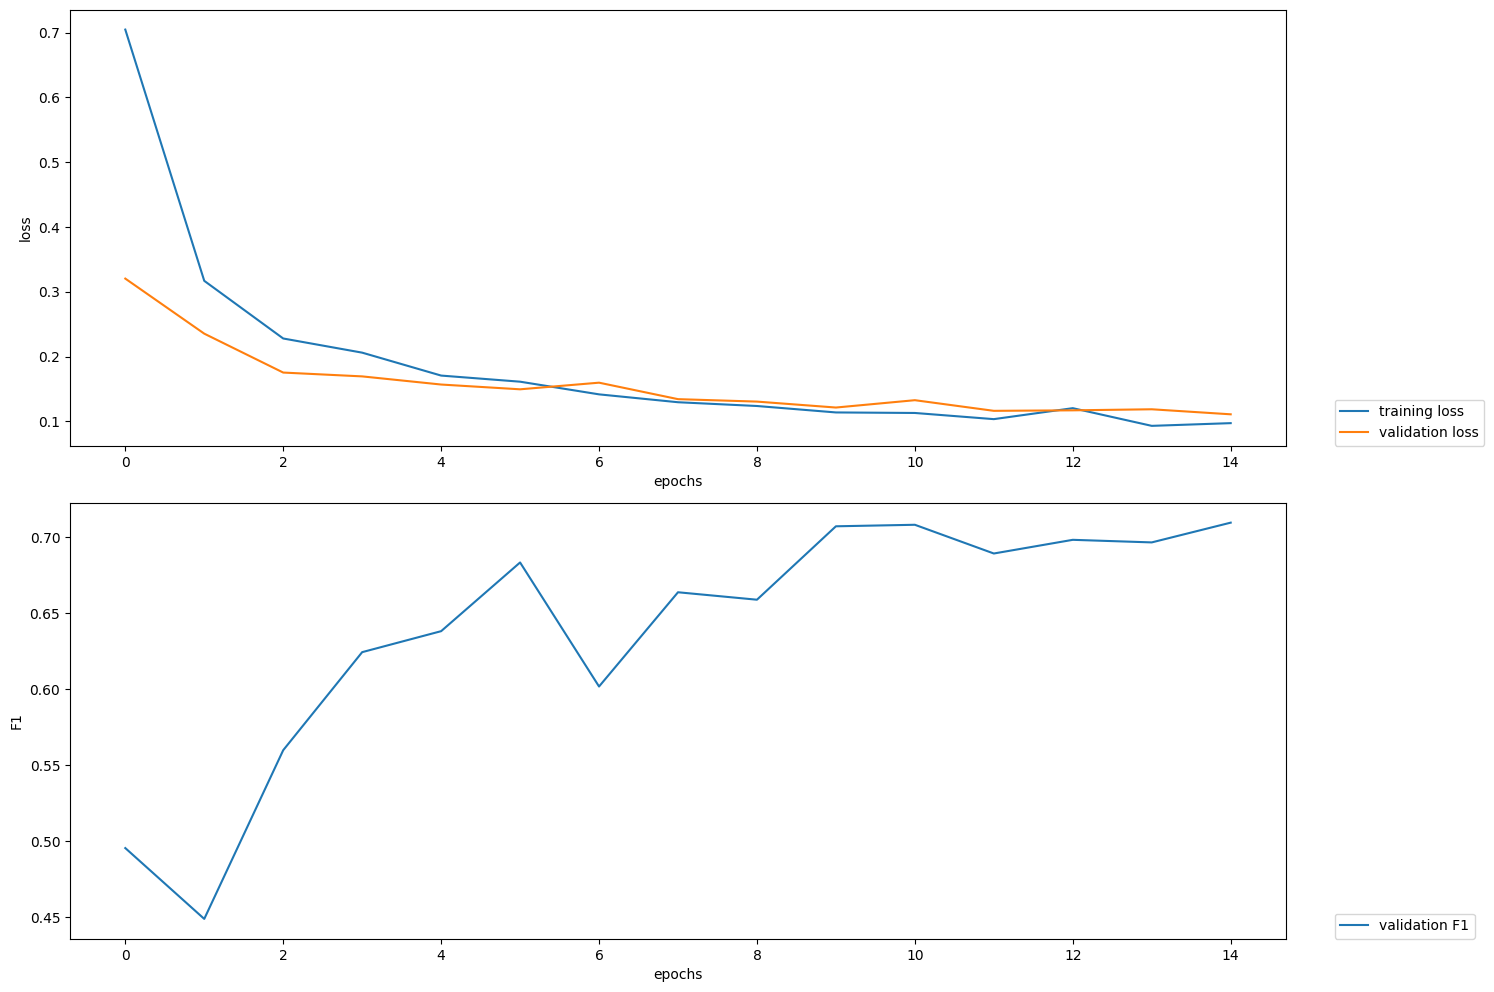

2023-09-26 07:14:21,772 Weights plots are saved in /content/drive/MyDrive/HAPLAPMaster/HAPLAPThesis/Seq-labeler/Flair-FR/Flair-ECHR-train-FR/Flair-Hug-model-FR-all-rev-shuffled/weights.png


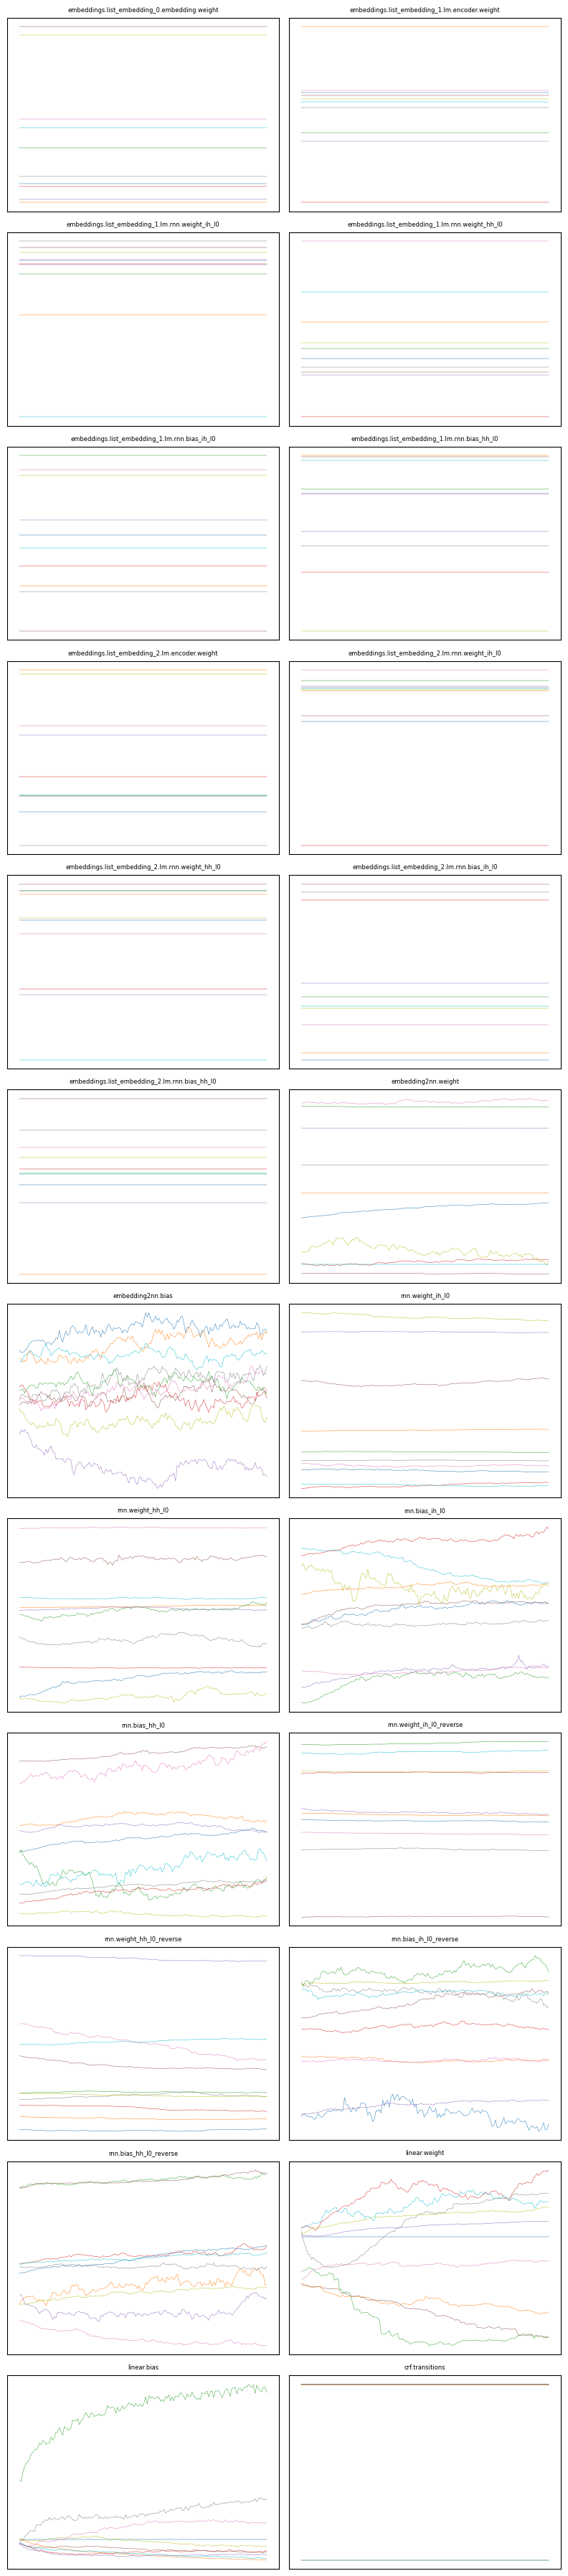

In [12]:
# plot training loss and weights
# Check documentation on training models with Flair

from flair.visual.training_curves import Plotter

plotter = Plotter()
plotter.plot_training_curves('/content/drive/MyDrive/.../loss.tsv')
plotter.plot_weights('/content/drive/MyDrive/.../weights.txt')